### Imports

In [1]:
# Adding packages
using Pkg
Pkg.add("CellBasedModels")
Pkg.add("GLMakie")

# Enabling packages
using CellBasedModels
using GLMakie

Makie.inline!(true);

   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


### Code

#### Construct the AgentBasedModel (ABM)

In [2]:
model = ABM(2,

    #In the keyword argument agent we declare all the agent arguments and its scope
    agent = Dict(
        :fx => Float64,
        :fy => Float64,
        ),

    #In the keyword argument model we declare all the model arguments and its scope
    model = Dict(
        :rRep => Float64,
        :fRep => Float64,
        :rAtr => Float64,
        :fAtr => Float64,
        :D => Float64
        ),

    # In here we define the ODE part
    agentODE = quote
        # Compute adhesion and repulsion forces
            # Reset the parameters to zero zero
        fx = 0
        fy = 0
            # Go over the neighbors and add the forces, for that we use the macro @loopOverNeighbors
        @loopOverNeighbors i2 begin
            d = CBMMetrics.euclidean(x,x[i2],y,y[i2])
            dirx = (x-x[i2])/d
            diry = (y-y[i2])/d
            if d < rRep # Repulsion forces
                fx += fRep*(rRep-d)*dirx
                fy += fRep*(rRep-d)*diry
            elseif d < rAtr # Attraction forces
                fx += -fAtr*(rAtr-d)*dirx
                fy += -fAtr*(rAtr-d)*diry
            end
        end
            # Add the forces comming from the boundary interaction
        if x < simBox[1,1]+rRep/2
            fx += fRep
        elseif x > simBox[1,2]-rRep/2
            fx -= fRep
        end
        if y < simBox[2,1]+rRep/2
            fy += fRep
        elseif y > simBox[2,2]/2
            fy -= fRep
        end
    
        # Finally, define the deterministic terms of the SDE
        dt(x) = fx
        dt(y) = fy
    end,

    # In here we define the SDE part
    agentSDE = quote
        # SDE term
        dt(x) = D
        dt(y) = D 
    end
);

#### Tests

##### Test repulsion from other agents

In [3]:
simBox = [-5. 5; -2 2]
#Initialize community
com = Community(model,
        N=2,
        dt=.1,
        simBox = simBox
        );

#Setup user paramaters
        #Constants
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
        #Agent parameters
com.x=[-.1,.1]
com.y=[0.,0.];
# If we do not define fx and fy, they are initialy set to zeros

2-element Vector{Float64}:
 0.0
 0.0

In [4]:
evolve!(com,steps=50)

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\s361359\.julia\packages\SciMLBase\8XHkk\src\performance_warnings.jl:32


In [5]:
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0…
  :y  => [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0…
  :fx => [[-0.6, 0.6], [-0.6, 0.6], [-0.48, 0.48], [-0.36, 0.36], [-0.264, 0.26…
  :t  => [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0  …  4.1, 4.2, 4.3, 4…
  :x  => [[-0.1, 0.1], [-0.16, 0.16], [-0.22, 0.22], [-0.268, 0.268], [-0.304, …

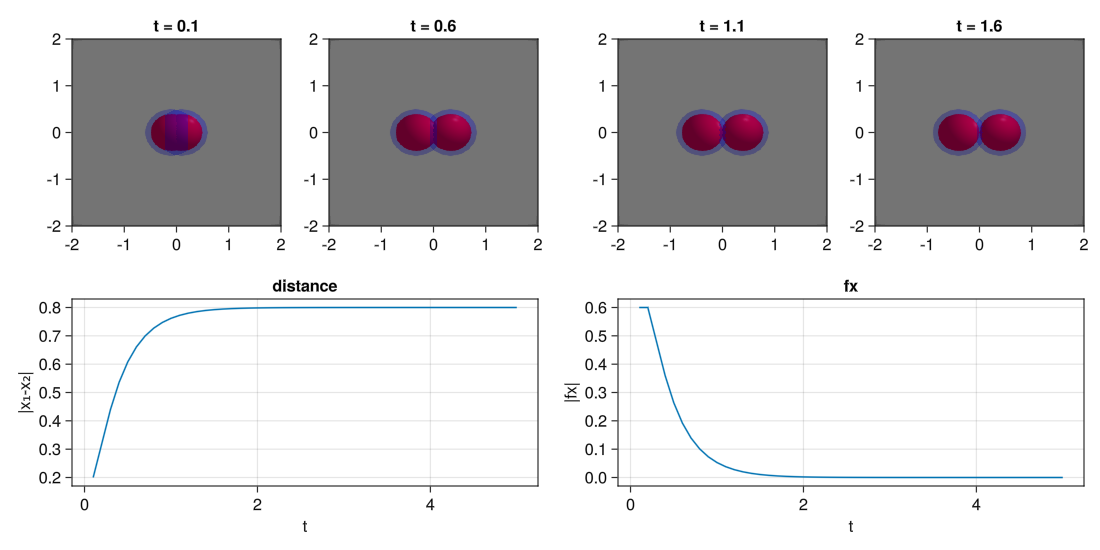

In [6]:
#Make the plot
fig = Figure(resolution=(1100,550))

#Plot the spheres at different times
for (j,i) in enumerate(1:5:20) #Step times
    #Create axis
    ax = Axis(fig[1,j],title="t = $(round(d[:t][i],digits=2))")
    #Add a simulation box rectangle in the background
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    #Add spheres with attraction radius    
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    #Add spheres with attraction radius
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,color=:red)
    #Define the limits
    xlims!(ax,-2,2)
    ylims!(ax,-2,2)
end

#Plot position over time of one of the particles
ax = Axis(fig[2,1:2],title="distance",xlabel="t",ylabel="|x₁-x₂|")
lines!(d[:t],[abs(j-i) for (i,j) in d[:x]])

#Plot forces over time of one of the particles
ax = Axis(fig[2,3:4],title="fx",xlabel="t",ylabel="|fx|")
lines!(d[:t],[abs(i) for (i,j) in d[:fx]])

#Show the plots
display(fig)
save("C:/Users/s361359/CellBasedModelsF1/results/particle_aggregation_repulsion_agents_example.png", fig)

##### Test repulsion from the boundaries

In [7]:
simBox = [-2. 2; -2 2]
#Initialize community
com = Community(model,
        N=1,
        dt=.1,
        simBox = simBox,
        );

#Setup user paramaters
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
com.x=[0]
com.y=[-2.5];

In [8]:
#Evolve
evolve!(com,steps=15)

In [9]:
#Get parameters
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0],…
  :y  => [[-2.5], [-2.4], [-2.3], [-2.2], [-2.1], [-2.0], [-1.9], [-1.8], [-1.7…
  :fx => [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],…
  :t  => [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,…
  :x  => [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],…

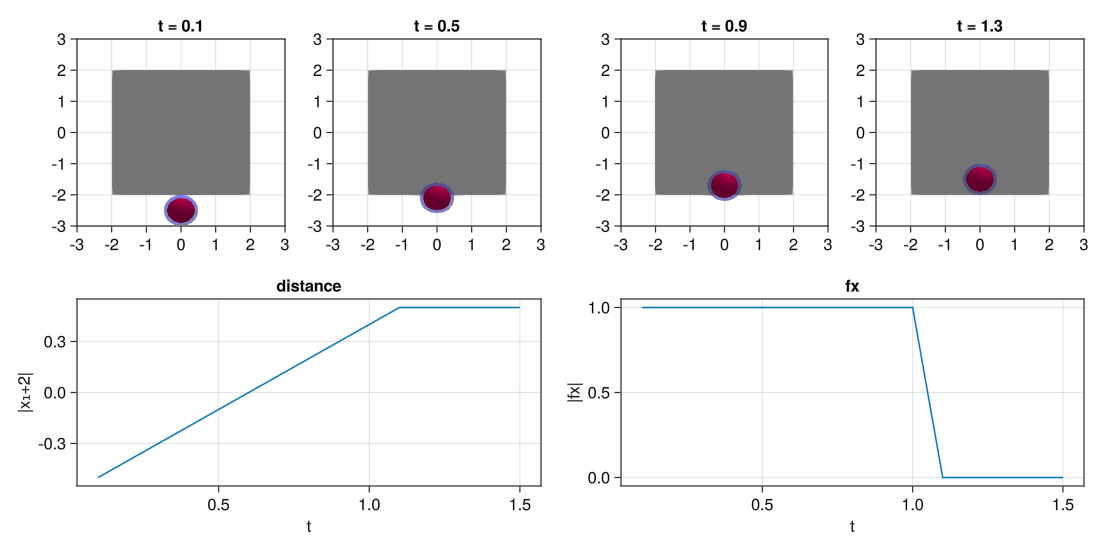

In [10]:
#Plot
fig = Figure(resolution=(1100,550))

#Plot visually the results
for (j,i) in enumerate(1:4:13)
    ax = Axis(fig[1,j],title="t = $(round(d[:t][i],digits=2))")
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,-3,3)
    ylims!(ax,-3,3)
end

#Plot position in i
ax = Axis(fig[2,1:2],title="distance",xlabel="t",ylabel="|x₁+2|")
lines!(d[:t],[i+2 for (i,) in d[:y]])

#Plot forces in i
ax = Axis(fig[2,3:4],title="fx",xlabel="t",ylabel="|fx|")
lines!(d[:t],[abs(i) for (i,) in d[:fy]])

display(fig)
save("C:/Users/s361359/CellBasedModelsF1/results/particle_aggregation_repulsion_boundaries_example.png", fig)

#### Constructing over a predefined model